<a href="https://colab.research.google.com/github/shobhitsundriyal/Revisit_ML/blob/master/Cnn_toxic_comment_classification_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Multiclass Classification

In [0]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [0]:
! kaggle competitions download -c 'jigsaw-toxic-comment-classification-challenge'

In [6]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [7]:
!wget 'http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip'

--2020-05-22 00:13:57--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  2.08MB/s    in 6m 30s  

2020-05-22 00:20:27 (2.11 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [8]:
!unzip 'glove.6B.zip'

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPool1D, Conv1D, MaxPool1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score

In [0]:
MAX_SEQUENCE_LENGTH = 200
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 30

In [12]:
word2vec = {}

with open(f'glove.6B.{EMBEDDING_DIM}d.txt') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.array(values[1:], dtype='float32')
    word2vec[word] = vec
print(f'Found {len(word2vec)} word vectors')

Found 400000 word vectors


In [13]:
train = pd.read_csv('train.csv')
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [15]:
train.shape

(159571, 8)

In [16]:
sentences = train.comment_text
possible_labels = ['toxic',	'severe_toxic',	'obscene',	'threat',	'insult',	'identity_hate']
targets = train[possible_labels].values
targets

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [18]:
targets.shape

(159571, 6)

In [19]:
print('Max Sentence length:', max(len(s) for s in sentences))
print('Min Sentence length:', min(len(s) for s in sentences))

Max Sentence length: 5000
Min Sentence length: 6


##### Tokenization

In [0]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [21]:
len(sequences)

159571

In [22]:
len(sequences[10])

499

In [23]:
len(sentences[10].split())

494

In [24]:
word2idx = tokenizer.word_index
print('No of unique tokens', len(word2idx))

No of unique tokens 210337


In [0]:
#print(word2idx)

In [26]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
data.shape

(159571, 200)

In [0]:
#Preparing embedding matrix
# Filling pretrained embeddings
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word) # if not present returns null
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [0]:
# load pretrained word embeddings into embedding layer
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False, # keeping these vectors fixed
    #trainable=True
)

In [0]:
# Building rest of model
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPool1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPool1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPool1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

model = Model(input_, output)
model.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

In [76]:
his = model.fit(
    data,
    targets,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT
)

Train on 127656 samples, validate on 31915 samples
Epoch 1/30
127656/127656 [==============================] - 7s 58us/step - loss: 0.0855 - accuracy: 0.9728 - val_loss: 0.0717 - val_accuracy: 0.9761
Epoch 2/30
127656/127656 [==============================] - 7s 56us/step - loss: 0.0697 - accuracy: 0.9768 - val_loss: 0.0980 - val_accuracy: 0.9676
Epoch 3/30
127656/127656 [==============================] - 7s 56us/step - loss: 0.0654 - accuracy: 0.9777 - val_loss: 0.0864 - val_accuracy: 0.9713
Epoch 4/30
127656/127656 [==============================] - 7s 56us/step - loss: 0.0626 - accuracy: 0.9785 - val_loss: 0.0770 - val_accuracy: 0.9759
Epoch 5/30
127656/127656 [==============================] - 7s 56us/step - loss: 0.0602 - accuracy: 0.9790 - val_loss: 0.0738 - val_accuracy: 0.9758
Epoch 6/30
127656/127656 [==============================] - 7s 56us/step - loss: 0.0579 - accuracy: 0.9796 - val_loss: 0.0804 - val_accuracy: 0.9769
Epoch 7/30
127656/127656 [=============================

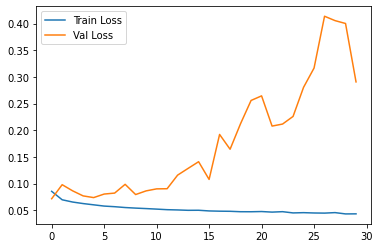

In [77]:
plt.plot(his.history['loss'], label='Train Loss')
plt.plot(his.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

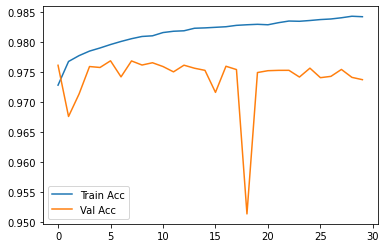

In [78]:
plt.plot(his.history['accuracy'], label='Train Acc')
plt.plot(his.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.show()

In [79]:
p = model.predict(data)
aucs = []

for j in range(6):
  auc = roc_auc_score(targets[:,j], p[:,j])
  aucs.append(auc)
np.mean(aucs)

0.97230131672283

In [39]:
!unzip test.csv.zip

Archive:  test.csv.zip
  inflating: test.csv                


In [40]:
!unzip sample_submission.csv.zip

Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   


In [42]:
sub = pd.read_csv('sample_submission.csv')
sub.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5


In [44]:
test = pd.read_csv('test.csv')
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [45]:
test_sentences = test.comment_text
print('Max Sentence length in test:', max(len(s) for s in test_sentences))
print('Min Sentence length in test:', min(len(s) for s in test_sentences))

Max Sentence length in test: 5000
Min Sentence length in test: 1


In [46]:
test.shape

(153164, 2)

In [47]:
test_sequences = tokenizer.texts_to_sequences(test_sentences)
len(test_sequences)

153164

In [49]:
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_data.shape

(153164, 200)

In [80]:
pred = model.predict(test_data)
pred.shape

(153164, 6)

In [53]:
sub.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5


In [81]:
'''
toxic = pred[:, 0]
s_t = pred[:, 1]
obs = pred[:, 2]
threat = pred[:, 3]
insult = pred[:, 4]
hate = pred[:, 5]
'''
for i in range(6):
  sub.iloc[:, i+1] = pred[:, i]

sub.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.991690,2.358870e-01,9.086770e-01,6.801471e-02,4.637896e-01,1.092731e-02
1,0000247867823ef7,0.000063,3.180293e-18,3.096474e-08,1.451660e-21,8.461996e-09,2.632542e-13
2,00013b17ad220c46,0.156866,8.878217e-03,1.187582e-01,8.356482e-03,1.150035e-01,2.779903e-02
3,00017563c3f7919a,0.000077,5.176345e-17,1.306909e-07,1.777508e-19,1.685352e-08,6.380085e-12
4,00017695ad8997eb,0.023688,1.337861e-06,5.451787e-03,9.713567e-07,3.146314e-03,1.477491e-04


In [0]:
sub.to_csv('submit-30epoch.csv', index=False)

Emmbeding layer not training, 10 epochs
Kaggle score = 0.90689

In [83]:
!kaggle competitions submit -c jigsaw-toxic-comment-classification-challenge -f "submit-30epoch.csv" -m "Embed false 30epochs"

100% 13.1M/13.1M [00:04<00:00, 2.85MB/s]
Successfully submitted to Toxic Comment Classification Challenge